# Training Example

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import os
import albumentations as A
from project.scripts.models import get_model
from project.scripts.viz_utils import show_image
import timm

import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

from project.scripts.training import train_model

## Training

In [64]:
num_classes = 16
num_epochs = 10
batch_size = 1
K_FOLD = 3
seed = 16

In [52]:
model = get_model('inception_v3.tv_in1k')

In [53]:
# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
model_transforms = timm.data.create_transform(**data_config, is_training=True)

In [54]:
transforms = A.Compose([
    A.Resize(height=300, width=300, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.MotionBlur(p=0.2),  # use motion blur 
        A.MedianBlur(blur_limit=3, p=0.1),  # use median blur
        A.Blur(blur_limit=3, p=0.1),  # use blur
    ], p=0.2),
    A.OneOf([
        A.GaussNoise(),  # add gauss noise
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),  # shift scale rotate
    A.RandomBrightnessContrast(p=0.2),  # random brightness contrast
])

In [55]:
from project.scripts.augmentation import CoinDataset

dataset = CoinDataset(
    image_dir=os.path.join(os.getcwd(), 'train_annotated'),
    transform=transforms,
    preprocess=model_transforms
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


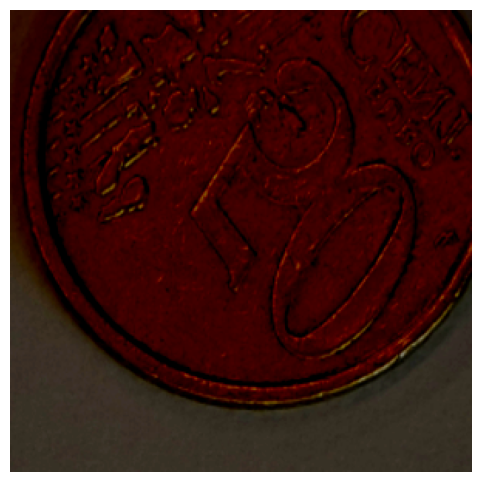

In [56]:
image, label = dataset[0]
_ = show_image(image.numpy().transpose(1, 2, 0))

In [57]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [65]:
# Record K-fold results in a (K_FOLD, num_epoch) matrix
training_losses = []
validation_losses = []
training_f1s = []
validation_f1s = []

k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=seed)

# Get training and validation indices
for fold, (train_idx, val_idx) in enumerate(k_fold.split(dataset)):

    print(f'fold: {fold}')
    
    train_smpl = SubsetRandomSampler(train_idx)
    val_smpl = SubsetRandomSampler(val_idx)

    # Create training and validation loaders
    train_loader = DataLoader(dataset, sampler=train_smpl, batch_size=batch_size)
    valid_loader = DataLoader(dataset, sampler=val_smpl, batch_size=batch_size)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=(len(train_loader.dataset) * num_epochs) // batch_size
    )
    
    # Train model
    train_losses, valid_losses, train_f1s, valid_f1s = train_model(
        model, (train_loader, valid_loader), criterion, optimizer, scheduler, num_epochs
    )

    # Save epoch results
    training_losses.append(train_f1s)
    validation_losses.append(train_f1s)
    training_f1s.append(train_f1s)
    validation_f1s.append(valid_f1s)

fold: 0


Epoch:  10. Validation. Loss: 6.799: 100%|██████████| 2/2 [00:00<00:00, 12.38it/s]


fold: 1


Epoch:  10. Validation. Loss: 4.023: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


fold: 2


Epoch:  10. Validation. Loss: 0.520: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]
